In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy

In [2]:
%load_ext PWE_NB_Extension

In [3]:
# type brighntess population


In [4]:
%%dlv --donot-run --donot-display_input -lci edb_instance

emp("Jones",   30000, 35, "Accounting").
emp("Miller",  38000, 29, "Marketing").
emp("Koch",  2000000, 24, "IT").
emp("Nguyen",  35000, 42, "Marketing").
emp("Gruber",  32000, 39, "IT").

dept("IT",         "Atlanta").
dept("Marketing",  "New York").
dept("Accounting", "Los Angeles").



In [5]:
%%dlv --donot-run -lci ebd_instance --donot-display_input

emp("Sun",100,1).
emp("Moon",10,2).
emp("Planet",1,8).

limit(1..10).
%q(Ename,Emag,Epop,X) :- emp(Ename,Emag,Epop), Epop > limit(X).
n(X) :- limit(X).



In [6]:
%%dlv --donot-run -lci dlv_rules --donot-display_input

q(Ename,Emag,Epop,X) :- emp(Ename,Emag,Epop), n(X), Epop > X.


%q1(Ename,Emag,Epop,X) :- q("Planet",1,8,X).

In [7]:
%dlv -l dlv_rules ebd_instance -wfs --save_meta_data_to meta_data --saveto dlv_soln --donot-display_input


Output:


'True: {emp("Sun",100,1), emp("Moon",10,2), emp("Planet",1,8), limit(1), limit(2), limit(3), limit(4), limit(5), limit(6), limit(7), limit(8), limit(9), limit(10), q("Moon",10,2,1), q("Planet",1,8,1), q("Planet",1,8,2), q("Planet",1,8,3), q("Planet",1,8,4), q("Planet",1,8,5), q("Planet",1,8,6), q("Planet",1,8,7), n(1), n(2), n(3), n(4), n(5), n(6), n(7), n(8), n(9), n(10)}\nUndefined: {}'

In [155]:
%dlv -l ebd_instance -wfs --save_meta_data_to meta_data --saveto dlv_soln --donot-display_input


Output:


'True: {emp("Sun",100,1), emp("Moon",10,2), emp("Planet",1,8), limit(1), limit(2), limit(3), limit(4), limit(5), limit(6), limit(7), limit(8), limit(9), limit(10), n(1), n(2), n(3), n(4), n(5), n(6), n(7), n(8), n(9), n(10)}\nUndefined: {}'

In [24]:
%%dlv --donot-run -lci ebd_instance --donot-display_input

data("Sun",100,1).
data("Sun",1000,10).
data("Moon",10,2).
data("Planet",1,8).

limit(1..10).
n(X) :- limit(X).


In [27]:
%%dlv --donot-run -lci dlv_rules --donot-display_input

%q(Ename,Emag,Epop,X) :- data(Ename,Emag,Epop), n(X), Epop > X.

q2(U,V,W) :- data(U,V,W), U = "Sun", .
%q1(Ename,Emag,Epop,X) :- q("Planet",1,8,X).

In [28]:
%dlv -l dlv_rules ebd_instance -wfs --save_meta_data_to meta_data --saveto dlv_soln --donot-display_input


Output:


'True: {data("Sun",100,1), data("Sun",1000,10), data("Moon",10,2), data("Planet",1,8), limit(1), limit(2), limit(3), limit(4), limit(5), limit(6), limit(7), limit(8), limit(9), limit(10), q2("Sun",100,1), q2("Sun",1000,10), n(1), n(2), n(3), n(4), n(5), n(6), n(7), n(8), n(9), n(10)}\nUndefined: {}'

In [ ]:
%%clingo --donot-run --donot-display_input -lci hamming_gv_rules
hamming_gv(X,Y,green) :- hamming(X,Y,2).
hamming_gv(X,Y,blue) :- hamming(X,Y,3).
hamming_gv(X,Y,red) :- hamming(X,Y,5).

%graphviz graph graph_type=directed rankdir=LR
%graphviz edge hamming_gv(TAIL,HEAD,_) color=$3

In [4]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = ''
    for x in dataValues:
        clingoStart += 'data('+','.join(x)
        clingoStart += ',black).'
        clingoStart += ('\n')
    return clingoStart

In [5]:
dataValues = [['"Sun"','"big"','1'],['"Planet"','"medium"','8'],['"Moon"','"small"','2']]

print(makeOriginal(dataValues))

data("Sun","big",1,black).
data("Planet","medium",8,black).
data("Moon","small",2,black).



In [12]:
def makeSelect(dataValues,colour='orange'):
    # max one item select, update to multiple later
    clingoStart = ''
    variables = [chr(65+x) for x in range(len(dataValues[0]))]
    variString = ','.join(variables)
    print(variString)
    print(dataValues)
    for dataVal in dataValues:
        for y in range(len(dataVal)):
            clingoStart += 'data('+variString+','+colour+') :- data('+variString+',_), '+variables[y]+'='+dataVal[y]+'.\n' 
        
    return clingoStart

In [53]:
def makeSelect(dataValues,colour='orange'):
    clingoStart = ''
    variables = [chr(65+x) for x in range(len(dataValues[0]))]  # doesn't work for over 26 variables but easy to fix
    clingoStart = ''
    variString = ','.join(variables)
    for dataVal in dataValues:
        for x in range(len(variables)):
            for y in range(len(dataVal)):
                start = y
                end = y+x+1
                if end > len(variables):
                    end += -len(variables)-1
                    templistvar = variables[end:end+1]
                    templistvar.extend(variables[start:])
                    templistdataVal = dataVal[end:end+1]
                    templistdataVal.extend(dataVal[start:])
                else:
                    templistvar = variables[start:end]
                    templistdataVal = dataVal[start:end]
                listcomp = [v+'='+d+'.' for v,d in zip(templistvar,templistdataVal)]
                #print("".join(listcomp))
                finalString = "".join(listcomp)
                clingoStart += 'data('+variString+','+colour+') :- data('+variString+',_), '+finalString+'\n' 
    return clingoStart

In [49]:
variables = ['A','B','C']
dataVal = ['"Sun"', '"big"', '1']
#for x in range(len(dataValues)):
#for y in range(len(dataValues)):
#variableBit = [x+'='+y+'.\n' for x,y in zip(variString,dataValues)]
clingoStart = ''
for x in range(len(variables)):
    for y in range(len(dataVal)):
        start = y
        end = y+x+1
        if end > len(variables):
            end += -len(variables)-1
            templistvar = variables[end:end+1]
            templistvar.extend(variables[start:])
            templistdataVal = dataVal[end:end+1]
            templistdataVal.extend(dataVal[start:])
#             print(start,end)
#             print(templistvar)
#             print(templistdataVal)
        else:
            templistvar = variables[start:end]
            templistdataVal = dataVal[start:end]
        listcomp = [v+'='+d+'.' for v,d in zip(templistvar,templistdataVal)]
        #print("".join(listcomp))
        finalString = "".join(listcomp)
        clingoStart += 'data('+variString+','+colour+') :- data('+variString+',_), '+finalString+'\n' 
print(clingoStart)

A="Sun".
B="big".
C=1.
A="Sun".B="big".
B="big".C=1.
A="Sun".C=1.
A="Sun".B="big".C=1.
A="Sun".B="big".C=1.
B="big".C=1.



In [36]:
print(variables[0:1])

['A']


In [54]:
dataValues = [['"Sun"','"big"','1'],['"Planet"','"medium"','8'],['"Moon"','"small"','2']]

print(makeSelect(dataValues))

data(A,B,C,orange) :- data(A,B,C,_), A="Sun".
data(A,B,C,orange) :- data(A,B,C,_), B="big".
data(A,B,C,orange) :- data(A,B,C,_), C=1.
data(A,B,C,orange) :- data(A,B,C,_), A="Sun".B="big".
data(A,B,C,orange) :- data(A,B,C,_), B="big".C=1.
data(A,B,C,orange) :- data(A,B,C,_), A="Sun".C=1.
data(A,B,C,orange) :- data(A,B,C,_), A="Sun".B="big".C=1.
data(A,B,C,orange) :- data(A,B,C,_), A="Sun".B="big".C=1.
data(A,B,C,orange) :- data(A,B,C,_), B="big".C=1.
data(A,B,C,orange) :- data(A,B,C,_), A="Planet".
data(A,B,C,orange) :- data(A,B,C,_), B="medium".
data(A,B,C,orange) :- data(A,B,C,_), C=8.
data(A,B,C,orange) :- data(A,B,C,_), A="Planet".B="medium".
data(A,B,C,orange) :- data(A,B,C,_), B="medium".C=8.
data(A,B,C,orange) :- data(A,B,C,_), A="Planet".C=8.
data(A,B,C,orange) :- data(A,B,C,_), A="Planet".B="medium".C=8.
data(A,B,C,orange) :- data(A,B,C,_), A="Planet".B="medium".C=8.
data(A,B,C,orange) :- data(A,B,C,_), B="medium".C=8.
data(A,B,C,orange) :- data(A,B,C,_), A="Moon".
data(A,B,C,o

In [99]:
def makeProject(dataValues,colour='red'):
    # right now only removes one column, remove N-1 later
    clingoStart = ''
    variables = [chr(65+x) for x in range(len(dataValues[0]))] # doesn't work for over 26 variables but easy to fix
    variString = ','.join(variables)
    for loop in range(len(variables)-1):
        for x in range(len(variables)):
            newVariables = [x for x in variables]
            otherNewVariables = [x for x in variables]
            start = x
            end = x + loop +1
            if end > len(variables)-1:
                end += - len(variables)
                donotRemove = [val for val in range(end,start)]
                removeKeys = [val for val in range(len(variables)) if val not in donotRemove]
            else:
                removeKeys = [val for val in range(start,end)]

            for remove in removeKeys:
                newVariables[remove] = '_'
                otherNewVariables[remove] = '""'
            newVariString = ','.join(newVariables)
            otherNewVariString = ','.join(otherNewVariables)
            clingoStart += 'data('+otherNewVariString+','+colour+') :- data('+newVariString+',_).\n' 

    return clingoStart

In [58]:
x = 150
string = ''

while x > 90:
    x += - 26
    z += 1
string += chr(65+z)
string += chr(x) 
print(string)

DH


In [64]:
x = [y for y in range(3,15)]
print(x)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [100]:
print(makeProject(dataValues))

data("",B,C,red) :- data(_,B,C,_).
data(A,"",C,red) :- data(A,_,C,_).
data(A,B,"",red) :- data(A,B,_,_).
data("","",C,red) :- data(_,_,C,_).
data(A,"","",red) :- data(A,_,_,_).
data("",B,"",red) :- data(_,B,_,_).



In [ ]:
def makeJoin():
    

In [ ]:
data(X,Y,'',colour) :- data(X,Y,_,_)

In [266]:
temlist = [0,1]
newtemlist = [x for x in temlist]
newtemlist.replace(0,'zebra')
print(temlist,newtemlist)

AttributeError: 'list' object has no attribute 'replace'

In [224]:

clingoStart = ''
for x in dataValues:
    clingoStart += 'data('
    for y in x:
        clingoStart += str(y)+','
    clingoStart = clingoStart[:-1]
    clingoStart += ')'
    clingoStart += ('\n')
    
print(clingoStart)

data("Sun","big",1,black)
data("Planet","medium",8,black)
data("Moon","small",2,black)



In [ ]:
for x in dataValues:
    

In [202]:
%%clingo --donot-run --donot-display_input -lci hamming_gv_rules

data("Sun","big",1,black).
data("Moon","small",2,black).
data("Planet","medium",8,black).



In [204]:
%%clingo -l hamming_gv_rules --donot-display_input --save_meta_data_to md --saveto sail_out


%query1(X,Y,Z) :- data(X,Y,Z).

data(X,Y,Z,orange) :- data(X,Y,Z,_).


data("database",X,Y,Z,"Join\nSun",blue,A,B,C) :- data(X,Y,Z), data(A,B,C), A=X.
data("database",X,Y,Z,"JoinMoon",green,A,B,C) :- data(X,Y,Z), data(A,B,C), B=Y.
data("database",X,Y,Z,"JoinPlanet",red,A,B,C) :- data(X,Y,Z), data(A,B,C), C=Z.

data(N,X,Y,Z,"Select",orange) :- data(_,X,Y,Z,N,Colour,A,B,C).


%result(N,"Sun",Y,Z,"Result",6) :- select(_,X,Y,Z,N,5).



Output:


'Answer: 1\ndata("Sun",100,1) data("Moon",10,2) data("Planet",1,8) data("database","Sun",100,1,"Join\\nSun",blue,"Sun",100,1) data("database","Moon",10,2,"Join\\nSun",blue,"Moon",10,2) data("database","Planet",1,8,"Join\\nSun",blue,"Planet",1,8) data("database","Sun",100,1,"JoinMoon",green,"Sun",100,1) data("database","Moon",10,2,"JoinMoon",green,"Moon",10,2) data("database","Planet",1,8,"JoinMoon",green,"Planet",1,8) data("database","Sun",100,1,"JoinPlanet",red,"Sun",100,1) data("database","Moon",10,2,"JoinPlanet",red,"Moon",10,2) data("database","Planet",1,8,"JoinPlanet",red,"Planet",1,8) data("Join\\nSun","Sun",100,1,"Select",orange) data("Join\\nSun","Moon",10,2,"Select",orange) data("Join\\nSun","Planet",1,8,"Select",orange) data("JoinMoon","Sun",100,1,"Select",orange) data("JoinMoon","Moon",10,2,"Select",orange) data("JoinMoon","Planet",1,8,"Select",orange) data("JoinPlanet","Sun",100,1,"Select",orange) data("JoinPlanet","Moon",10,2,"Select",orange) data("JoinPlanet","Planet",1,8,"Select",orange)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.000s'

In [196]:
%%clingo -l hamming_gv_rules --donot-display_input --save_meta_data_to md --saveto sail_out


query1(X,Y,Z) :- data(X,Y,Z).
join("database",X,Y,Z,"Join\nSun",blue,A,B,C) :- query1(X,Y,Z), query1(A,B,C), A=X.
join("database",X,Y,Z,"JoinMoon",green,A,B,C) :- query1(X,Y,Z), query1(A,B,C), B=Y.
join("database",X,Y,Z,"JoinPlanet",red,A,B,C) :- query1(X,Y,Z), query1(A,B,C), C=Z.

select(N,X,Y,Z,"Select",orange) :- join(_,X,Y,Z,N,Colour,A,B,C).


%result(N,"Sun",Y,Z,"Result",6) :- select(_,X,Y,Z,N,5).

%graphviz graph graph_type=directed rankdir=LR
%graphviz edge join(HEAD,_,_,_,TAIL,_,_,_,_) color=$6
%graphviz edge select(HEAD,_,_,_,TAIL,_) color=$6
%graphviz edge result(HEAD,_,_,_,TAIL,_) color=$6


Output:


'Answer: 1\ndata("Sun",100,1) data("Moon",10,2) data("Planet",1,8) query1("Sun",100,1) query1("Moon",10,2) query1("Planet",1,8) join("database","Sun",100,1,"Join\\nSun",blue,"Sun",100,1) join("database","Moon",10,2,"Join\\nSun",blue,"Moon",10,2) join("database","Planet",1,8,"Join\\nSun",blue,"Planet",1,8) join("database","Sun",100,1,"JoinMoon",green,"Sun",100,1) join("database","Moon",10,2,"JoinMoon",green,"Moon",10,2) join("database","Planet",1,8,"JoinMoon",green,"Planet",1,8) join("database","Sun",100,1,"JoinPlanet",red,"Sun",100,1) join("database","Moon",10,2,"JoinPlanet",red,"Moon",10,2) join("database","Planet",1,8,"JoinPlanet",red,"Planet",1,8) select("Join\\nSun","Sun",100,1,"Select",orange) select("Join\\nSun","Moon",10,2,"Select",orange) select("Join\\nSun","Planet",1,8,"Select",orange) select("JoinMoon","Sun",100,1,"Select",orange) select("JoinMoon","Moon",10,2,"Select",orange) select("JoinMoon","Planet",1,8,"Select",orange) select("JoinPlanet","Sun",100,1,"Select",orange) select("JoinPlanet","Moon",10,2,"Select",orange) select("JoinPlanet","Planet",1,8,"Select",orange)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.000s'

In [205]:
pw_rel_dfs, schemas, pw_objs = load_worlds(sail_out, md, print_parse_tree=False, reasoner='clingo')

Number of Models: 1


In [206]:
pw_rel_dfs.keys()

dict_keys(['data_3', 'data_9', 'data_6'])

In [213]:
pw_rel_dfs['data_6']

,pw,x1,x2,x3,x4,x5,x6
0,1,"""Join\nSun""","""Sun""",100,1,"""Select""",orange
1,1,"""Join\nSun""","""Moon""",10,2,"""Select""",orange
2,1,"""Join\nSun""","""Planet""",1,8,"""Select""",orange
3,1,"""JoinMoon""","""Sun""",100,1,"""Select""",orange
4,1,"""JoinMoon""","""Moon""",10,2,"""Select""",orange
5,1,"""JoinMoon""","""Planet""",1,8,"""Select""",orange
6,1,"""JoinPlanet""","""Sun""",100,1,"""Select""",orange
7,1,"""JoinPlanet""","""Moon""",10,2,"""Select""",orange
8,1,"""JoinPlanet""","""Planet""",1,8,"""Select""",orange


In [ ]:
G = nx.Graph()
edges = []
for i, row in pw_rels_dfs[edge_rel_name].iterrows():
    start_node = "{}".format(''.join([row[col] for col in edge_init_col_names]))
    end_node = "{}".format(''.join([row[col] for col in edge_end_col_names]))
    G.add_edge(start_node, end_node, penwidth=2)
    edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
G.graph['layout'] = 'neato'
G.graph['rankdir'] = 'TB'

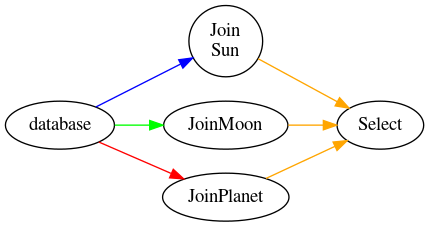

In [200]:
g = PWEVisualization.graphviz_from_meta_data(pw_rel_dfs, md['graphviz'])
draw(g)

In [178]:
md

{'temporal_dec': {},
 'attr_def': {},
 'graphviz': {'graph': {'styles': [('graph_type', 'direct', 'directed'),
    ('rankdir', 'direct', 'LR')],
   'graph_type': 'directed'},
  'node': {},
  'edge': {'join_9': {'head': 4,
    'tail': 0,
    'styles': [('color', 'arg_idx', 6)],
    'ord': 1},
   'select_6': {'head': 4,
    'tail': 0,
    'styles': [('color', 'arg_idx', 6)],
    'ord': 1},
   'result_6': {'head': 4,
    'tail': 0,
    'styles': [('color', 'arg_idx', 6)],
    'ord': 1}}}}

In [8]:
pw_rels_dfs, rel_schemas, pw_objs  = load_worlds(asp_output=dlv_soln, meta_data=meta_data, reasoner='dlv')

In [9]:
list(map(lambda x: x.__dict__, rel_schemas))


[{'relation_name': 'q_4', 'arity': 4, 'r_id': 0, 'meta_data': {}},
 {'relation_name': 'limit_1', 'arity': 1, 'r_id': 1, 'meta_data': {}},
 {'relation_name': 'n_1', 'arity': 1, 'r_id': 2, 'meta_data': {}},
 {'relation_name': 'emp_3', 'arity': 3, 'r_id': 3, 'meta_data': {}}]

In [54]:
input_viz = colorability_viz(pw_rel_dfs, 1, fill_type='filled')
draw(input_viz)

NameError: name 'colorability_viz' is not defined

In [11]:
pw_rels_dfs['q_4']

,wfs_status,x1,x2,x3,x4
0,true,"""Moon""",10,2,1
1,true,"""Planet""",1,8,1
2,true,"""Planet""",1,8,2
3,true,"""Planet""",1,8,3
4,true,"""Planet""",1,8,4
5,true,"""Planet""",1,8,5
6,true,"""Planet""",1,8,6
7,true,"""Planet""",1,8,7
